## Analysis pipline for *Why pathway methods work?* project

All required data (and also analysis results) to repruduce results can be downloaded at https://doi.org/10.5281/zenodo.4139875.

### Preprocess gene sets

In [1]:
from subprocess import call
import os
import sys
import pickle as pckl

sys.path.append('../code/')

In [2]:
import numpy as np
import pandas as pd

At first we create pickled Pyhton dict-s from the original (R based) DoRothEA and msigdb gene sets.

In [3]:
#getting csv regulons from DoRothEA
call(['Rscript','../code/get_regulon_from_rdata.R'])

0

In [4]:
#getting csv gene sets from msigdb
call(['Rscript','../code/get_msigdb_genesets.R'])

0

In [3]:
import make_genesets

In [6]:
#prepocess dorothea regulons
for confidence in ['A','B','C','D','E','BEST']:
    make_genesets.make_gene_dict_dorothea(confidence)

In [7]:
#multi level gene sets for dorothea
make_genesets.make_multi_level_dorothea()

In [8]:
#confidence levels for BEST dorothea
make_genesets.make_different_level_BEST_dorothea()

In [9]:
#make multi level dorothea BEST, that is what we will use
make_genesets.make_multi_level_dorothea_BEST()

In [10]:
#prepocess msigdb regulons
for setname in ['BIOCARTA','CGP','KEGG','REACTOME']:
    make_genesets.make_gene_dict_msigdb(setname)

As the size of the different gene sets has a wide distribution, we will concentrate in this work only on gene sets with <=250 genes.

In [11]:
#use only <=250 gene sets
for dname in ['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']:
    data=pd.read_csv('../results/genesets/single/csvs/%s.csv' %dname,sep=',',header=0,index_col=0)
    fil=data['Set'].value_counts()<=250
    sets=data['Set'].value_counts().index[fil]
    fil=np.in1d(data['Set'],sets)
    data=data[fil]
    data.to_csv('../results/genesets/single/csvs/%s_filtered.csv' % dname,sep=',')

We will also use random gene sets as background distribution. We will use 5 x 200 random gene sets, generated based on our original gene sets (DoRothEA, KEGG etc.). We use two randomization startegy:

* random genes samped uniformly from the genes of the original gene set database, gene set sizes are sampled from the original gene set database
* genes are sampled with the probablity corresponding in the original gene set database, gene set sizes are sampled from the original gene set database

In [23]:
#strategy 1
#make random gene sets
np.random.seed(527)
for dname in ['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']:
    data=pd.read_csv('../results/genesets/single/csvs/%s_filtered.csv' %dname,sep=',',header=0,index_col=0)
    sizes=data['Set'].value_counts().values
    genes=list(set(data['Gene']))
    genes.sort()
    for i in range(3):
        random_set=pd.DataFrame(columns=['Set','Gene'])
        for j in range(len(data['Set'].unique())):
            l=np.random.choice(sizes,1)[0]
            random_subset=pd.DataFrame(index=range(l),columns=['Set','Gene'])
            random_subset['Set']='Random_%s_uniform_%i' % (dname,j)
            random_subset['Gene']=np.random.choice(genes,l,False)
            random_set=pd.concat([random_set,random_subset])
            random_set.index=range(len(random_set))
        random_set.to_csv('../results/genesets/single/csvs/%s_random_uniform_%i.csv' % (dname,i),sep=',')

In [24]:
#strategy 2
#make random gene sets
np.random.seed(527)
for dname in ['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']:
    data=pd.read_csv('../results/genesets/single/csvs/%s_filtered.csv' %dname,sep=',',header=0,index_col=0)
    sizes=data['Set'].value_counts().values
    genes=data['Gene'].value_counts()
    genes = genes.sort_index()
    genes=genes/genes.sum()
    for i in range(3):
        random_set=pd.DataFrame(columns=['Set','Gene'])
        for j in range(len(data['Set'].unique())):
            l=np.random.choice(sizes,1)[0]
            random_subset=pd.DataFrame(index=range(l),columns=['Set','Gene'])
            random_subset['Set']='Random_%s_dist_%i' % (dname,j)
            random_subset['Gene']=np.random.choice(genes.index,l,False,p=genes.values)
            random_set=pd.concat([random_set,random_subset])
            random_set.index=range(len(random_set))
        random_set.to_csv('../results/genesets/single/csvs/%s_random_dist_%i.csv' % (dname,i),sep=',')

Calculate gene set similarity

In [4]:
import geneset_similarity

In [26]:
setnames1=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
setnames2=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
for setname1 in setnames1:
    print(setname1)
    for setname2 in setnames2:
        if setname1<setname2:
            geneset_similarity.get_composational_similarity(setname1+'_filtered',setname2+'_filtered')
            for i in range(3):
                geneset_similarity.get_composational_similarity(setname1+'_random_uniform_%i' % i,
                                                               setname2+'_random_uniform_%i' % i)
                geneset_similarity.get_composational_similarity(setname1+'_random_dist_%i' % i,
                                                               setname2+'_random_dist_%i' % i)

BEST_dorothea_AB
BEST_dorothea_CD
KEGG
BIOCARTA
REACTOME
CGP


We will create also overlap and set difference gene sets.

In [27]:
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for dataset in datasets:
    make_genesets.make_pickle_from_genese(dataset+'_filtered')
    for i in range(3):
        make_genesets.make_pickle_from_genese(dataset+'_random_uniform_%i' % i)
        make_genesets.make_pickle_from_genese(dataset+'_random_dist_%i' % i)

In [29]:
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for dataset1 in datasets:
    for dataset2 in datasets:
        if dataset1<dataset2:
            make_genesets.make_overlap_gene_sets(dataset1+'_filtered',dataset2+'_filtered')
            for i in range(3):
                make_genesets.make_overlap_gene_sets(dataset1+'_random_uniform_%i' % i,
                                                               dataset2+'_random_uniform_%i' % i)
                make_genesets.make_overlap_gene_sets(dataset1+'_random_dist_%i' % i,
                                                               dataset2+'_random_dist_%i' % i)

And we create RData files (for viper) from all gene sets.

In [30]:
#make rdata file from the gene sets for viper
call(['Rscript','../code/make_viper_regulon.R'])

0

### Preprocess benchamrking datasets
Now as we are having our gene sets (and gene set similarities) ready, we need the benchmarking datasets. For benchmarking we will use 2 datasets:
* perturbation gene expression profiles form PROGENy
* mutation associated signatures from the GDSC study

PROGENy data preprocess:

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
#PROGENY prepocess
zscores=pd.read_csv('../data/progeny/zscores_14PW_PROGENy.csv',sep=',',header=0,index_col=0)
indexes=pd.read_csv('../data/progeny/index_14PW_PROGENy.csv',sep=',',header=0,index_col=0)
indexes.index=indexes['id']
del indexes['id']

In [11]:
np.sum(zscores.isna().sum(1)==0)

6684

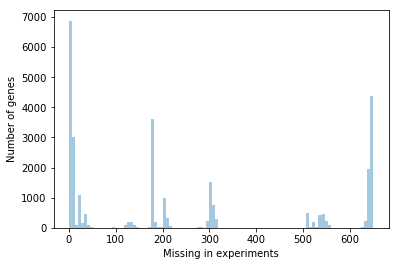

In [12]:
#removing NAs
sns.distplot(zscores.isna().sum(1),norm_hist=False,kde=False,bins=100)
plt.xlabel('Missing in experiments')
plt.ylabel('Number of genes')

In [13]:
#we keep only genes with 0 missing values
fil=zscores.isna().sum(1)==0
zscores=zscores[fil]

In [14]:
#WNT3 is mislabelled, it is WNT correctly
fil=indexes['pathway']=='WNT3'
indexes.loc[indexes.index[fil],'pathway']='WNT'

In [15]:
assert np.sum(indexes.index!=zscores.columns)==0

In [16]:
#multiply gene expressions with the sign of perturbation
zscores=zscores*indexes['sign']

In [17]:
zscores.to_csv('../results/benchmark/datasets/progeny_data.csv',sep=',')
pd.DataFrame(indexes['pathway']).to_csv('../results/benchmark/datasets/progeny_meta.csv',sep=',')

GDSC data preprocess

We normalise gene expression tissue-wise, to remove potential tissue specific effects.

In [18]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [19]:
#gdsc data
gex=pd.read_csv('../data/gdsc/gex.csv',sep=',',header=0,index_col=0)
gex=gex[gex.columns[pd.Series(gex.columns).apply(lambda x: '.' not in x).values]]
gex.columns=gex.columns.astype(int)
cell_anno=pd.read_excel('../data/gdsc/Cell_Lines_Details.xlsx',skipfooter=1)
meta=pd.read_csv('../data/gdsc/PANCAN_simple_MOBEM.rdata.tsv',sep='\t',header=0,index_col=0)
meta.columns=meta.columns.astype(int)

In [20]:
#filter for TCGA descriptor
fil=~(cell_anno['Cancer Type\n(matching TCGA label)'].isnull())
cell_anno=cell_anno[fil]

In [21]:
cosmics=list(set(cell_anno['COSMIC identifier'])&set(gex.columns)&set(meta.columns))
gex=gex[cosmics]
fil=np.in1d(cell_anno['COSMIC identifier'],cosmics)
cell_anno=cell_anno[fil]
meta=meta[cosmics]
meta=meta[pd.Series(meta.index).apply(lambda x:"_mut" in x).values]

In [22]:
counts=cell_anno['Cancer Type\n(matching TCGA label)'].value_counts()
tissue=counts[counts>20].index
fil=np.in1d(cell_anno['Cancer Type\n(matching TCGA label)'],tissue)
cell_anno=cell_anno[fil]
gex=gex[cell_anno['COSMIC identifier'].values]
meta=meta[gex.columns]

In [23]:
#keep only mutations with >=6 cell lines
meta=meta[meta.sum(1)>=6]

In [24]:
tissues=cell_anno['Cancer Type\n(matching TCGA label)'].unique()

In [25]:
for t in tissues:
    print(t)
    cosmics=cell_anno[cell_anno['Cancer Type\n(matching TCGA label)']==t]['COSMIC identifier'].values
    gex_t=gex[cosmics]
    m=np.mean(gex_t,1)
    s=np.std(gex_t,1)
    s_p=lowess(np.std(gex_t,1),np.mean(gex_t,1),return_sorted=False)
    gex_t=((gex_t.T-m)/s_p).T
    gex.loc[gex_t.index,gex_t.columns]=gex_t

HNSC
ESCA
LAML
DLBC
ALL
BRCA
COAD/READ
STAD
KIRC
LUAD
SCLC
MESO
GBM
NB
PAAD
SKCM
OV


In [26]:
meta.to_csv('../results/benchmark/datasets/gdsc_meta.csv',sep=',')
gex.round(3).to_csv('../results/benchmark/datasets/gdsc_data.csv',sep=',')

### Calculating gene activity scores on benchmark data

In [3]:
### Do not run local, it takes some time

In [101]:
call(['Rscript','../code/run_viper.R'])

0

In [ ]:
### benchmark scores (calculate ROC AUCs)
### it takes a rather long time
call(['python3','../code/benchmark_all.py'])

In [ ]:
### merge the different benchmark files
call(['python3','../code/merge_rocaucs.py'])

In [2]:
### from here you can run local

Let's calcualte z-scores.

In [5]:
#progeny
data = pd.read_csv('../results/benchmark/rocaucs/progeny/random.csv', sep=',', header=0, index_col=0)

In [6]:
random_mean = data.mean()
random_std = data.std()
n_s = pd.read_csv('../results/benchmark/datasets/progeny_meta.csv', sep=',', header=0, index_col=0)
n_s = n_s['pathway'].value_counts()
n_s = n_s[random_mean.index]

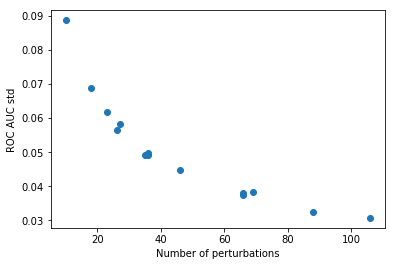

In [9]:
### relationshipt between the std of random 
plt.plot(n_s, random_std, 'o')
plt.xlabel('Number of perturbations')
plt.ylabel('ROC AUC std')

In [10]:
fnames = os.listdir('../results/benchmark/rocaucs/progeny/single/')
for fname in fnames:
    if fname[-4:] == '.csv':
        data = pd.read_csv('../results/benchmark/rocaucs/progeny/single/' + fname,
                          sep=',', header=0, index_col=0)
        data = (data - random_mean) / random_std
        data.to_csv('../results/benchmark/z_scores/progeny/single/' + fname, sep=',')

In [11]:
fnames = os.listdir('../results/benchmark/rocaucs/progeny/overlap_merged//')
for fname in fnames:
    if fname[-4:] == '.csv':
        data = pd.read_csv('../results/benchmark/rocaucs/progeny/overlap_merged//' + fname,
                          sep=',', header=0, index_col=0)
        data = (data - random_mean) / random_std
        data.to_csv('../results/benchmark/z_scores/progeny/overlap/' + fname, sep=',')

In [12]:
#gdsc
data = pd.read_csv('../results/benchmark/rocaucs/gdsc/random.csv', sep=',', header=0, index_col=0)

In [13]:
random_mean = data.mean()
random_std = data.std()
n_s = pd.read_csv('../results/benchmark/datasets/gdsc_meta.csv', sep=',', header=0, index_col=0)
n_s = n_s.sum(1)
n_s = n_s[random_mean.index]

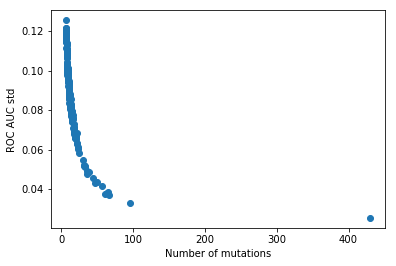

In [14]:
### relationshipt between the std of random 
plt.plot(n_s, random_std, 'o')
plt.xlabel('Number of mutations')
plt.ylabel('ROC AUC std')

In [15]:
fnames = os.listdir('../results/benchmark/rocaucs/gdsc/single/')
for fname in fnames:
    if fname[-4:] == '.csv':
        data = pd.read_csv('../results/benchmark/rocaucs/gdsc/single/' + fname,
                          sep=',', header=0, index_col=0)
        data = (data - random_mean) / random_std
        data.to_csv('../results/benchmark/z_scores/gdsc/single/' + fname, sep=',')

In [16]:
fnames = os.listdir('../results/benchmark/rocaucs/gdsc/overlap_merged//')
for fname in fnames:
    if fname[-4:] == '.csv':
        data = pd.read_csv('../results/benchmark/rocaucs/gdsc/overlap_merged//' + fname,
                          sep=',', header=0, index_col=0)
        data = (data - random_mean) / random_std
        data.to_csv('../results/benchmark/z_scores/gdsc/overlap/' + fname, sep=',')

### Generate Omnipath distance matrix

In [27]:
data=pd.read_csv('../data/omnipath/interactions.txt',sep='\t',header=0,index_col=None)

In [28]:
data.head()

,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,dip_url
0,P17612,P55064,1,0,0,1,0,0,NaN
1,P55064,Q9HBA0,0,0,0,0,0,0,NaN
2,O43318,Q00610,1,0,0,1,0,0,NaN
3,P14672,Q00610,1,0,0,1,0,0,NaN
4,Q00610,P14672,1,0,0,1,0,0,NaN


In [29]:
#split complexes
fil1=data['source'].apply(lambda x:'COMPLEX' in x)
fil2=data['target'].apply(lambda x:'COMPLEX' in x)
data_comp=data[fil1|fil2].copy()
data_nocomp=data[~(fil1|fil2)].copy()

In [30]:
#create interactions for complex members
data_comp_good=pd.DataFrame(columns=data_comp.columns)
for i in data_comp.index:
    targets=data_comp.loc[i,'target']
    sources=data_comp.loc[i,'source']
    if 'COMPLEX' in targets:
        targets=targets.split('COMPLEX:')[1].split('-')
    else:
        targets=[targets]
    if 'COMPLEX' in sources:
        sources=sources.split('COMPLEX:')[1].split('-')
    else:
        sources=[sources]
    info=list(data_comp.loc[i].values[2:])
    for s in sources:
        for t in targets:
            new=pd.DataFrame(index=[0],columns=data_comp_good.columns)
            new.loc[0]=[s,t]+info
            data_comp_good=data_comp_good.append(new,ignore_index=True)

In [31]:
data_good=pd.concat([data_nocomp,data_comp_good],ignore_index=True)

In [32]:
data_good=data_good[['source','target']]
data_good.to_csv('../data/omnipath/all_interactions.csv',sep=',')

In [35]:
#we will translate the nodes to human readable
call(['Rscript','../code/gene_name_conversion.R'])
data=pd.read_csv('../data/omnipath/all_interactions.csv',sep=',',header=0,index_col=0)
idconv=pd.read_csv('../data/omnipath/omnipath_uni_hgnc.csv',sep=',',header=0,index_col=0)

In [36]:
#prepare id conversion
fil=idconv.isnull().sum(1)==0
idconv=idconv[fil]
idconv=idconv.drop_duplicates('uniprotswissprot')
idconv=idconv.drop_duplicates('hgnc_symbol')
idconv.index=idconv['uniprotswissprot']
idconv=idconv['hgnc_symbol']

In [37]:
#filter network for human genes with symbol
fil=np.in1d(data['source'],idconv.index) & np.in1d(data['target'],idconv.index)
data=data[fil]
data['source']=idconv[data['source']].values
data['target']=idconv[data['target']].values

In [38]:
data.to_csv('../data/omnipath/all_interactions_hgnc.csv',sep=',')
data.head()

,source,target
0,PRKACA,AQP5
1,AQP5,TRPV4
2,MAP3K7,CLTC
3,SLC2A4,CLTC
4,CLTC,SLC2A4


In [39]:
#make network undirected
data_rev=pd.DataFrame(index=data.index,columns=data.columns)
data_rev['source']=data['target']
data_rev['target']=data['source']
data=pd.concat([data,data_rev],ignore_index=True)
data=data.drop_duplicates()

In [40]:
#remove self interacions
fil=data['source']!=data['target']
data=data[fil]
data.to_csv('../data/omnipath/all_interactions_hgnc_undirected.csv',sep=',')

In [42]:
#create adj. matirx
data['Interaction']=1
AM=data.pivot(index='source',columns='target',values='Interaction')
AM[AM.isnull()]=0
#add self edge
AM=AM+np.eye(N=len(AM))

In [43]:
AM=AM.astype(int)

In [44]:
AM.to_csv('../data/omnipath/AM.csv',sep=',')

In [45]:
AM.head()

target,A1BG,A1CF,A2M,AAAS,AAK1,AAMP,AANAT,AATF,AATK,ABAT,...,ZRANB3,ZSCAN21,ZSCAN4,ZSWIM7,ZW10,ZWILCH,ZWINT,ZXDC,ZYX,ZZZ3
source,,,,,,,,,,,,,,,,,,,,,
A1BG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
#calculate distance matrix
prot_ids=AM.index
AM=AM.values
DM=np.full((len(prot_ids),len(prot_ids)),np.inf)
RW=np.eye(len(prot_ids)) #starting position
k=0
DM[RW==1]=k
while True:
    k+=1
    #number of steps, remaining not reachable
    print(k,(DM==np.inf).sum())
    RW_new=np.dot(RW,AM)
    RW_new[RW_new!=0]=1
    if (RW_new!=RW).sum()==0:
        break
    DM[(RW_new==1)&(RW!=1)]=k
    RW=RW_new

1 82110782
2 82022318
3 79151600
4 57738322
5 26662404
6 12406978
7 8528338
8 7596260
9 7372498
10 7336040
11 7331546
12 7330972
13 7330890


In [47]:
AM=pd.DataFrame(AM,index=prot_ids,columns=prot_ids)
DM=pd.DataFrame(DM,index=prot_ids,columns=prot_ids)
DM.to_csv('../data/omnipath/DM.csv',sep=',')

In [48]:
#filter out unconnected nodes
n_unconnected=(DM==np.inf).sum().min()
giant_component=DM.index[(DM==np.inf).sum()==n_unconnected]
AM=AM.loc[giant_component,giant_component]
DM=DM.loc[giant_component,giant_component]

In [49]:
AM.to_csv('../data/omnipath/AM_GC.csv',sep=',')
DM.to_csv('../data/omnipath/DM_GC.csv',sep=',')

In [50]:
DM.head()

source,A1CF,A2M,AAAS,AAK1,AAMP,AANAT,AATF,AATK,ABCA1,ABCB1,...,ZRANB2,ZRANB3,ZSCAN21,ZSCAN4,ZW10,ZWILCH,ZWINT,ZXDC,ZYX,ZZZ3
source,,,,,,,,,,,,,,,,,,,,,
A1CF,0.0,3.0,4.0,5.0,4.0,4.0,3.0,4.0,4.0,4.0,...,4.0,5.0,6.0,4.0,5.0,7.0,4.0,5.0,3.0,5.0
A2M,3.0,0.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,3.0,...,3.0,3.0,5.0,5.0,4.0,6.0,4.0,4.0,3.0,4.0
AAAS,4.0,4.0,0.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,...,3.0,4.0,6.0,5.0,5.0,7.0,5.0,5.0,3.0,5.0
AAK1,5.0,3.0,5.0,0.0,5.0,4.0,4.0,4.0,4.0,3.0,...,4.0,4.0,6.0,4.0,5.0,7.0,4.0,5.0,4.0,4.0
AAMP,4.0,4.0,4.0,5.0,0.0,3.0,4.0,4.0,3.0,3.0,...,4.0,4.0,5.0,5.0,5.0,7.0,4.0,4.0,4.0,5.0
